# The Probability Integral Transform (PIT)

The probability intergral transform (PIT) provides a method for assessing to what extent a forecast system is probabililistically calibrated, and may help diagnose particular types of miscalibration. A forecast system is probabilistically calibrated if random draws from its predictive distributions are statistically indistinguishable from the corresponding observations.

The classical definition of the PIT for a particular forecast-observation case is $\mathrm{PIT}(F,y) = F(y)$, where $F$ is the predictive cumulative distribution function (CDF) and $y$ is the value of the observation. If the predictive CDFs are all continuous, and the forecast system is probabililistically calibrated, then the set of all PIT values $F(y)$ across the set of all forecast-observation cases will be approximately uniformly distributed on the unit interval $[0,1]$.

This definition of PIT needs adjustment to account for cases when the predictive CDFs are discontinuous. Dicontinuous CDFs commonly occur with forecasts of precipitation, which is a mixture distribution with two components: the probability of dry conditions and the probability of precipitation given that precipitation occurs. The `scores` implementation of PIT handles discontinuous predictive CDFs as well as continuous predictive CDFs. It does this by keeping track of left-hand and right-hand limits of $F(y)$. We'll get onto this later in the tutorial.

The `scores` implementation of PIT also handles inputs in three basic forms:

1. Inputs are the values $F(y)$ for each of the forecast-observation cases (or possibly the left-hand and right-hand limits of $F$ at $y$ if $F$ has discontinuities), as calculated by the user. This uses the class `scores.probability.Pit_fcst_at_obs`.
2. Inputs are the forecasts and corresponding observations, where the forecasts are in the form of an ensemble. In this case, the predictive CDFs are treated as empirical CDFs derived from the ensemble values. This uses the class `scores.probability.Pit` with the `fcst_type='ensemble'` option.
3. Inputs are the forecasts and corresponding observations, where the forecasts are arrays specifing the values (or left- and right-hand limits) of each predictive CDF at a specified set of points $x$. If an observation $y$ is not one of specified points $x$, then the value of $f$ at $y$ is deterrmined using linear interpolation. This uses the class `scores.probability.Pit` with the `fcst_type='cdf'` option.

Both PIT classes then have identical methods for calculating statistics for PIT histograms, PIT diagrams (i.e. PIT uniform probability plots), the variance and expected value of PIT across all forecast cases, and the so-called alpha score. These methods and classes are demonstrated in this tutorial.

For ensemble forecasts, `scores.probability.rank_histogram` also provides a method for computing rank histograms, which are closely related to PIT histograms. See the [tutorial on rank histograms](./Rank_Histogram.ipynbipynb) for further information.

## Case study 1: Predictive CDFs are parametric distributions and continous

This case study looks at predictive CDFs that are normal distributions. It will also examine some classic types of probabilistic (mis)-calibration
their characteristic PIT histograms and PIT uniform probability plots.

We consider a process $Y_t$, where $t=0, 1, \ldots, m$, which is generated by independent sampling from the normal distribution
as follows:
$$ Y_t \sim N(\mu_t, 1), \qquad\text{where } \mu_t\sim N(0, 1).$$

We consider six different forecasters who issue predictive CDFs as follows:

1. **Calibrated (ideal) forecaster**: forecasts are $N(\mu_t, 1)$.
2. **Over-prediction forecaster**: forecasts are $N(\mu_t + 0.3, 1)$. That is, forecast distribution lies to the right of the true distribution. 
3. **Under-prediction forecaster**: forecasts are $N(\mu_t - 0.3, 1)$. That is, forecast distribution lies to the left of the true distribution. 
4. **Over-dispersed forecaster**: forceasts are $N(\mu_t, (1.3)^2)$. That is, forecast distribution is wider than the true distribution. 
5. **Under-dispersed forecaster**: forceasts are $N(\mu_t, (1/1.3)^2)$. That is, forecast distribution is narrower than the true distribution. 
6. **Calibrated (marginal) forecaster**: forceasts are $N(0, 2)$. That is, this forecast distribution well-calibrated but has no knowledge of $\mu_t$. This is equivalent to issuing the climatological forecast for a meteorological process. Forecasts are reliable over the long-run but not accurate.

We'll generate some observations $y$, evaluate them at the forecast CDFs $F$, and then use the `Pit_fcst_at_obs` class to generate standard statistics and diagrams.



In [ ]:
import numpy as np
import xarray as xr
from scipy.stats import norm
import matplotlib.pyplot as plt
from scores.probability import Pit, Pit_fcst_at_obs


n_time = 10000  # total time steps

# generate values for mu_t
np.random.seed(seed=42)
mu = norm.rvs(loc = 0, scale = 1, size=n_time)

# generate the observations
obs = xr.DataArray(
    data=norm.rvs(loc = mu, scale = 1, size=n_time),
    dims=['case'],
    coords={'case': range(n_time)},
    name='obs',
)
# calculate the observations evaluated at the forecast CDFs
fcstA_at_obs = xr.DataArray(
    data=norm.cdf(obs, loc = mu, scale = 1),
    dims=['time'],
    coords={'time': range(n_time)},
    name='calibrated (ideal)',
)
fcstB_at_obs = xr.DataArray(
    data=norm.cdf(obs, loc = mu + 0.3, scale = 1),
    dims=['time'],
    coords={'time': range(n_time)},
    name='over-prediction',
)
fcstC_at_obs = xr.DataArray(
    data=norm.cdf(obs, loc = mu - 0.3, scale = 1),
    dims=['time'],
    coords={'time': range(n_time)},
    name='under-prediction',
)
fcstD_at_obs = xr.DataArray(
    data=norm.cdf(obs, loc = mu, scale = 1.3),
    dims=['time'],
    coords={'time': range(n_time)},
    name='over-dispersed',
)
fcstE_at_obs = xr.DataArray(
    data=norm.cdf(obs, loc = mu, scale = 1 / 1.3),
    dims=['time'],
    coords={'time': range(n_time)},
    name='under-dispersed',
)
fcstF_at_obs = xr.DataArray(
    data=norm.cdf(obs, loc = 0, scale = np.sqrt(2)),
    dims=['time'],
    coords={'time': range(n_time)},
    name='calibrated (marginal)',
)

# combine forecasts evaulated at obs into a list
fcst_at_obs_list = [fcstA_at_obs, fcstB_at_obs, fcstC_at_obs, fcstD_at_obs, fcstE_at_obs, fcstF_at_obs]

# generate the Pit class for each forecast system
pit_list = [Pit_fcst_at_obs(fcst_at_obs) for fcst_at_obs in fcst_at_obs_list]


### The PIT histogram

The PIT histogram displays the the relative frequency with which observations fall at different quantile levels of the predictive CDFs. If the forecast system is well calibrated then the histogram should be fairly flat. Let's look at the output of the `.hist_values` method, then produce a plot of the PIT histogram for each forecaster.

In [ ]:
# We'll calculate the histogram values for each forecast system

n_bins = 20  # number of bins in the PIT histogram
histogram_values = [pit.hist_values(n_bins) for pit in pit_list]

# look at the output for the "calibrated (ideal)" forecaster
histogram_values[0]

<xarray.DataArray 'calibrated (ideal)' (bin_centre: 20)> Size: 160B
array([0.05  , 0.051 , 0.0497, 0.0489, 0.0503, 0.0492, 0.0499, 0.0499,
       0.053 , 0.0489, 0.0514, 0.0492, 0.0483, 0.0502, 0.0509, 0.0481,
       0.0522, 0.0507, 0.0474, 0.0508])
Coordinates:
  * bin_centre          (bin_centre) float64 160B 0.025 0.075 ... 0.925 0.975
    bin_left_endpoint   (bin_centre) float64 160B 0.0 0.05 0.1 ... 0.85 0.9 0.95
    bin_right_endpoint  (bin_centre) float64 160B 0.05 0.1 0.15 ... 0.9 0.95 1.0

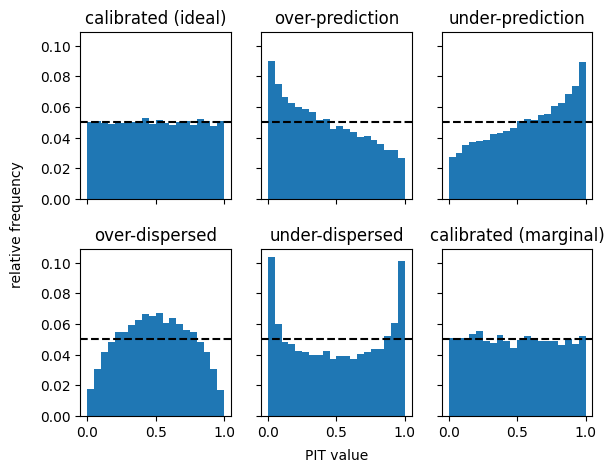

In [8]:
# now plot the rank histogram for each forecaster

fig, axes = plt.subplots(2, 3, sharex=True, sharey=True)

for histval, i in zip(histogram_values, range(6)):
    row, col = int(i / 3), i % 3
    axes[row, col].bar(histval['bin_centre'].values, histval.values, width=1/n_bins)
    axes[row, col].axhline(y=1/n_bins, color='k', linestyle='--')
    axes[row, col].set_title(histval.name)

plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.2, hspace=0.3)
fig.text(0.5, 0.01, 'PIT value', ha='center')
fig.text(-0.01, 0.5, 'relative frequency', va='center', rotation='vertical')

fig.show()

These illustrate basic characteristic shapes of PIT histograms.

- Calibrated forecasters (ideal and marginal) have flat histograms.
- Forecasters with dispersion issues have U-shaped or inverted U-shaped histograms, with too many observations falling either in the centre of the distribution (if over-dispersed) or in the tails of the distribution (if under-dispersed).
- Forecasters with bias (over- or under-prediction) have asymmetric histograms.

### PIT diagrams

PIT diagrams (similar to PIT uniform probability plots) provide another way of visualising miscalibration. A PIT diagram is a plot of graph of the empirical CDF of the PIT values for the set of forecast cases. If the PIT values are uniformly distributed, as would be the case for a probabilistically calibrated system, then graph will lie close to diagonal line, which is the graph of the CDF of the standard uniform distribution.

Plotting points for the PIT diagram are obtainable from the `.plotting_points()` method. Let's get the plotting points for all six forecasters and look at the output for the "calibrated (ideal)" forecaster.

In [9]:
plotting_points = [pit.plotting_points() for pit in pit_list]
plotting_points[0]

<xarray.DataArray 'calibrated (ideal)' (pit_x_value: 20004)> Size: 160kB
array([0., 0., 0., ..., 1., 1., 1.])
Coordinates:
  * pit_x_value  (pit_x_value) float64 160kB 0.0 0.0 1.161e-05 ... 1.0 1.0 1.0

Values in the array give the y-values for the PIT diagram, while values in the "pit_x_value" dimension give the corresponding x-values.

Here are the PIT diagrams for all 6 forecasters.

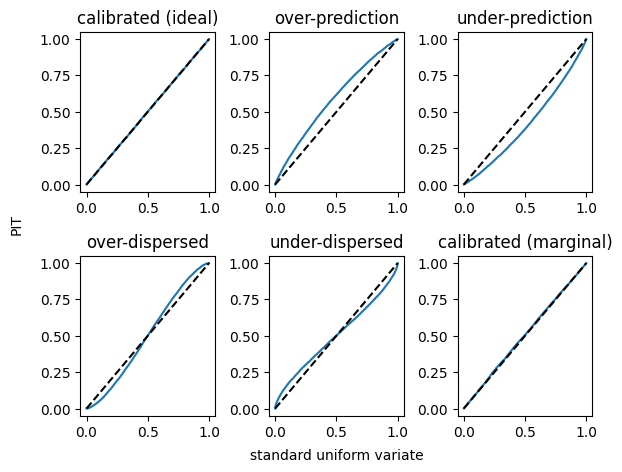

In [10]:
fig, axes = plt.subplots(2, 3)

for ppoints, i in zip(plotting_points, range(6)):
    row, col = int(i / 3), i % 3
    axes[row, col].plot(ppoints['pit_x_value'].values, ppoints.values)
    axes[row, col].plot([0, 1], [0, 1], color='k', linestyle='--')
    axes[row, col].set_title(ppoints.name)

plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.4, hspace=0.4)
fig.text(0.5, 0.01, 'standard uniform variate', ha='center')
fig.text(-0.01, 0.5, 'PIT', va='center', rotation='vertical')

fig.show()

The PIT diagrams give the characteristic shapes for different types of miscalibration.

Output from the `.plotting_points()` method gives duplicate values in the "pit_x_value" dimension. That is because the empirical distribution will has discontinuities (or veritical jumps in the plot). Duplicate values among coordinates can sometimes cause problems. The `plotting_points_parametric()` method provides the same information as `plotting_points` but without duplicate coordinate values.

### Expected value and Variance of PIT

The expected value and variance of the empirical PIT distribution can be useful statistics for diagnosing different types of miscalibration. If the forecasting system is calibrated then the distribution of PIT values will be approximately uniform, with an expected value of $1/2$ and a variance of $1/12$. Large departures from these values can indicate bias or dispersion problems with the forecast system. The `.expected_value()` and `.variance()` methods give the values.

In [12]:
# expected value of PIT for the "calibrated (ideal)" forecaster, which is close to 1/2
pit_list[0].expected_value()

<xarray.DataArray 'calibrated (ideal)' ()> Size: 8B
array(0.49969626)

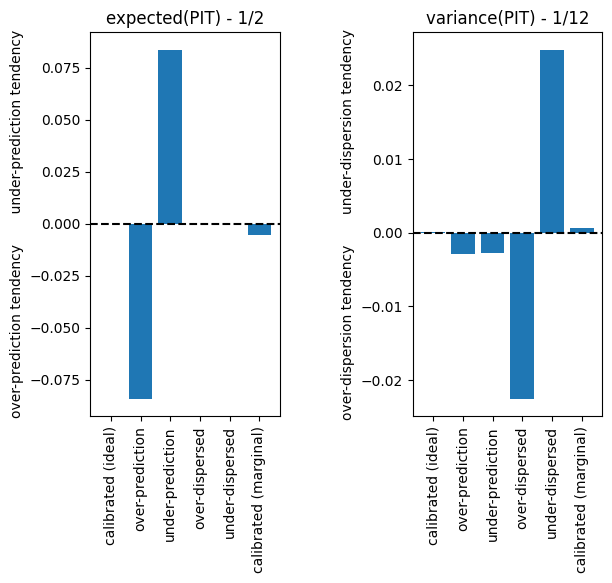

In [16]:
exp_values = [float(pit.expected_value() - 1/2) for pit in pit_list]
var_values = [float(pit.variance() - 1/12) for pit in pit_list]
fcst_labels = [fcst_at_obs.name for fcst_at_obs in fcst_at_obs_list]

fig, axes = plt.subplots(1, 2)

axes[0].axhline(y=0, color='k', linestyle='--')
axes[1].axhline(y=0, color='k', linestyle='--')

axes[0].set_ylabel('over-prediction tendency       under-prediction tendency')
axes[1].set_ylabel('over-dispersion tendency       under-dispersion tendency')


axes[0].bar(fcst_labels, exp_values)
axes[1].bar(fcst_labels, var_values)

axes[0].tick_params(axis='x', labelrotation=90)
axes[1].tick_params(axis='x', labelrotation=90)

axes[0].set_title('expected(PIT) - 1/2')
axes[1].set_title('variance(PIT) - 1/12')

plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=.7, hspace=0.4)

fig.show()

### The alpha score

The alpha score (Renard et al, 2010) is a summary statistic for the disparture of the PIT distribution for a set of forecast cases from the standard uniform distribution. It measures the integrated absolute difference between the PIT CDF and the standard uniform CDF (i.e., the area between the PIT diagram plot and the diagonal). The `.alpha_score` method calculates the values.

In [17]:
# alpha score for forecaster A
pit_list[0].alpha_score()

<xarray.DataArray ()> Size: 8B
array(0.0009678)

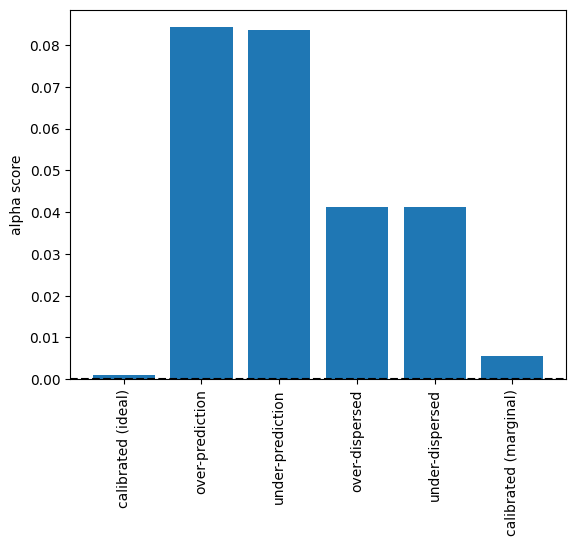

In [18]:
alpha_scores = [float(pit.alpha_score()) for pit in pit_list]

fig, axes = plt.subplots(1, 1)

axes.axhline(y=0, color='k', linestyle='--')
axes.set_ylabel('alpha score')

axes.bar(fcst_labels, alpha_scores)

axes.tick_params(axis='x', labelrotation=90)


#plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=.7, hspace=0.4)

fig.show()

The calibrated forecast systems have the lower alpha scores.

## Case 2: Predictive distributions are parametric with discontinuities

## Case 3: Predictions are in the form of ensemble forecasts

In [5]:
n_bins = 10  # number of bins for the histogram
hist_values = pit.hist_values(n_bins, right = True)
hist_values

<xarray.Dataset> Size: 320B
Dimensions:             (bin_centre: 10)
Coordinates:
  * bin_centre          (bin_centre) float64 80B 0.05 0.15 0.25 ... 0.85 0.95
    bin_left_endpoint   (bin_centre) float64 80B 0.0 0.1 0.2 0.3 ... 0.7 0.8 0.9
    bin_right_endpoint  (bin_centre) float64 80B 0.1 0.2 0.3 0.4 ... 0.8 0.9 1.0
Data variables:
    calibrated (ideal)  (bin_centre) float64 80B 0.0982 0.1032 ... 0.1001 0.1014

## Case 4: Predictions are CDFs (non-parametric)

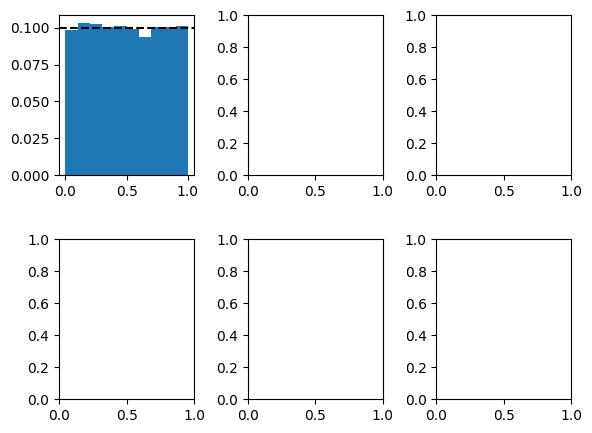

In [6]:
fig, axes = plt.subplots(2, 3)

for fcst_label, i in zip(list(hist_values.data_vars), range(6)):
    axes[int(i / 3), i % 3].bar(hist_values['bin_centre'].values, hist_values[fcst_label].values, width=1/n_bins)
    axes[int(i / 3), i % 3].axhline(y=1/n_bins, color='k', linestyle='--')

plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.4, hspace=0.4)

fig.show()

In [48]:
interp1d([0, 1, 1, 2, 3], [-10, 0, 2, 4, 0])([0.5, 1.5, 2.5])

array([-5.,  3.,  2.])

In [ ]:
x_pos = xr.DataArray(data=[0, 0.1, ])
y_pos = xr.DataArray(data=[0, 0.1, ])

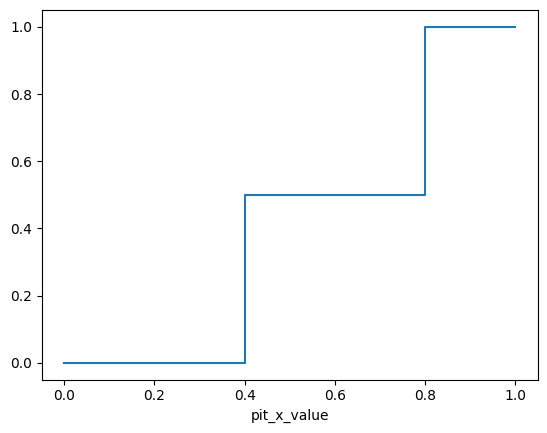

In [3]:
da = xr.DataArray(data=[0, 0, 0, 0.5, 0.5, 1, 1, 1], dims=["pit_x_value"], coords={"pit_x_value": [0, 0, 0.4, 0.4, 0.8, 0.8, 1, 1]})
x = da["pit_x_value"]
da.plot()

In [40]:
new_coords = [0.3, 0.5]
new_coords = xr.DataArray(data=np.repeat(np.nan, len(new_coords)), dims=['pit_x_value'], coords={'pit_x_value': new_coords})
new_coords,_ = xr.broadcast(new_coords, da)
new_coords

ValueError: cannot reindex or align along dimension 'pit_x_value' because the (pandas) index has duplicate values

In [41]:
xr.DataArray(
    data=[0, np.nan, 0, 0.5, 0.5, 1, 1, 1],
    dims=["pit_x_value"],
    coords={"pit_x_value": [0, 0, 0.4, 0.4, 0.8, 0.8, 1, 1]}
).interpolate_na("pit_x_value")

ValueError: Index 'pit_x_value' has duplicate values

In [29]:
x_pos = x.assign_coords(pit_x_value=np.arange(len(x.pit_x_value))).rename({'pit_x_value': 'plotting_point'})
y_pos = da.assign_coords(pit_x_value=np.arange(len(x.pit_x_value))).rename({'pit_x_value': 'plotting_point'})
y_pos

<xarray.DataArray (plotting_point: 8)> Size: 64B
array([0. , 0. , 0. , 0.5, 0.5, 1. , 1. , 1. ])
Coordinates:
  * plotting_point  (plotting_point) int64 64B 0 1 2 3 4 5 6 7

In [34]:
gradient = y_pos.diff("plotting_point") / x_pos.diff("plotting_point")
x_solution = (y_pos - gradient * x_pos) / (1 - gradient)
x_solution = x_solution.where(
    (x_solution < x_pos) & (x_solution > x_pos.shift(plotting_point=1))
)
x_solution

<xarray.DataArray (plotting_point: 7)> Size: 56B
array([nan, nan, nan, 0.5, nan, nan, nan])
Coordinates:
  * plotting_point  (plotting_point) int64 56B 1 2 3 4 5 6 7

In [27]:
x_diff = x_pos.diff("plotting_point")  # x1 - x0
y_diff = y_pos.diff("plotting_point")  # y1 - y0

grad_chord = y_diff / x_diff

intersection_points = (y_pos - grad_chord * x_pos) / (1 - grad_chord)

intersection_points = intersection_points.where(intersection_points < x_pos)
intersection_points = intersection_points.where(intersection_points > x_pos.shift(plotting_point=1))
intersection_points = np.unique(intersection_points.values.flatten())
intersection_points = intersection_points[~np.isnan(intersection_points)]
intersection_points






array([0.5])

In [ ]:
# insert the new values in with linear interpolation using add_thresholds


<xarray.DataArray 'pit_x_value' (pit_x_value: 7)> Size: 56B
array([0. , 0.4, 0. , 0.4, 0. , 0.2, 0. ])
Coordinates:
  * pit_x_value  (pit_x_value) float64 56B 0.0 0.4 0.4 0.8 0.8 1.0 1.0

In [8]:
y_diff

<xarray.DataArray (pit_x_value: 7)> Size: 56B
array([0. , 0. , 0.5, 0. , 0.5, 0. , 0. ])
Coordinates:
  * pit_x_value  (pit_x_value) float64 56B 0.0 0.4 0.4 0.8 0.8 1.0 1.0

In [18]:
import numpy as np

y = np.array([0, 0, 0, 0.5, 0.5, 1, 1, 1])
x = np.array([0, 0, 0.4, 0.4, 0.8, 0.8, 1, 1])
np.trapezoid(np.abs(y - x), x)

np.float64(0.18000000000000002)

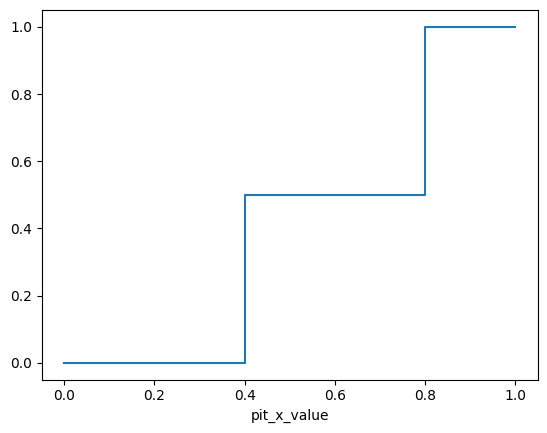

In [6]:
EXP_FAO_PP = xr.DataArray(data=[0, 0, 0, 0.5, 0.5, 1, 1, 1], dims=["pit_x_value"], coords={"pit_x_value": [0, 0, 0.4, 0.4, 0.8, 0.8, 1, 1]})
EXP_FAO_PP.plot()

In [ ]:
np.abs(EXP_FAO_PP - EXP_FAO_PP["pit_x_value"]).integrate("pit_x_value")

<xarray.DataArray ()> Size: 8B
array(0.18)

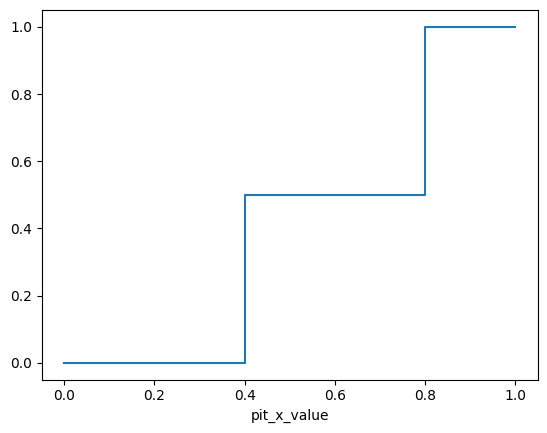

In [25]:
da = xr.DataArray(data=[0, 0, 0, 0.5, 0.5, 1, 1, 1], dims=["pit_x_value"], coords={"pit_x_value": [0, 0, 0.4, 0.4, 0.8, 0.8, 1, 1]})
x = da["pit_x_value"]

da.plot()

In [28]:
(da - x).diff("pit_x_value")

<xarray.DataArray (pit_x_value: 7)> Size: 56B
array([ 0. , -0.4,  0.5, -0.4,  0.5, -0.2,  0. ])
Coordinates:
  * pit_x_value  (pit_x_value) float64 56B 0.0 0.4 0.4 0.8 0.8 1.0 1.0

In [1]:
import numpy as np
import xarray as xr
from scipy.stats import norm
import matplotlib.pyplot as plt
from scores.probability import Pit

In [2]:
f"""Test this f string: {1+2}"""

'Test this f string: 3'

In [2]:


n_cases = 100000
n_member = 100

mu = norm.rvs(loc = 0, scale = 1, size=n_cases)

n_member = 100
mu_broadcast = np.broadcast_to(mu, (n_member, n_cases))



obs = xr.DataArray(
    data=norm.rvs(loc = mu, scale = 1, size=n_cases),
    dims=['case'],
    coords={'case': range(n_cases)},
    name='obs',
)



fcstA = xr.DataArray(
    data=norm.rvs(loc = mu_broadcast, scale = 1, size=(n_member,n_cases)),
    dims=['ens_member', 'case'],
    coords={'ens_member': range(n_member), 'case': range(n_cases)},
    name='fcstA',
)
fcstB = xr.DataArray(
    data=norm.rvs(loc = mu_broadcast + 0.25, scale = 1, size=(n_member,n_cases)),
    dims=['ens_member', 'case'],
    coords={'ens_member': range(n_member), 'case': range(n_cases)},
    name='fcstB',
)
fcstC = xr.DataArray(
    data=norm.rvs(loc = mu_broadcast - 0.25, scale = 1, size=(n_member,n_cases)),
    dims=['ens_member', 'case'],
    coords={'ens_member': range(n_member), 'case': range(n_cases)},
    name='fcstC',
)
fcstD = xr.DataArray(
    data=norm.rvs(loc = mu_broadcast, scale = 1.2, size=(n_member,n_cases)),
    dims=['ens_member', 'case'],
    coords={'ens_member': range(n_member), 'case': range(n_cases)},
    name='fcstD',
)
fcstE = xr.DataArray(
    data=norm.rvs(loc = mu_broadcast, scale = 1 / 1.2, size=(n_member,n_cases)),
    dims=['ens_member', 'case'],
    coords={'ens_member': range(n_member), 'case': range(n_cases)},
    name='fcstE',
)
fcstF = xr.DataArray(
    data=norm.rvs(loc = 0, scale = np.sqrt(2), size=(n_member,n_cases)),
    dims=['ens_member', 'case'],
    coords={'ens_member': range(n_member), 'case': range(n_cases)},
    name='fcstF',
)

fcst = xr.merge([fcstA, fcstB, fcstC, fcstD, fcstE, fcstF])

Now we'll calculate PIT

In [3]:


pit = Pit(fcst, obs, 'ens_member', fcst_type='ensemble', reduce_dims='all')


In [4]:
n_bins = 20
hist_values = pit.hist_values(n_bins, right = True)
hist_values

<xarray.Dataset> Size: 1kB
Dimensions:             (bin_centre: 20)
Coordinates:
  * bin_centre          (bin_centre) float64 160B 0.025 0.075 ... 0.925 0.975
    bin_left_endpoint   (bin_centre) float64 160B 0.0 0.05 0.1 ... 0.85 0.9 0.95
    bin_right_endpoint  (bin_centre) float64 160B 0.05 0.1 0.15 ... 0.9 0.95 1.0
Data variables:
    fcstA               (bin_centre) float64 160B 0.06088 0.05027 ... 0.04928
    fcstB               (bin_centre) float64 160B 0.09627 0.06762 ... 0.02915
    fcstC               (bin_centre) float64 160B 0.03604 0.03491 ... 0.08069
    fcstD               (bin_centre) float64 160B 0.03262 0.0399 ... 0.02496
    fcstE               (bin_centre) float64 160B 0.09723 0.05683 ... 0.0841
    fcstF               (bin_centre) float64 160B 0.05943 0.04983 ... 0.05009

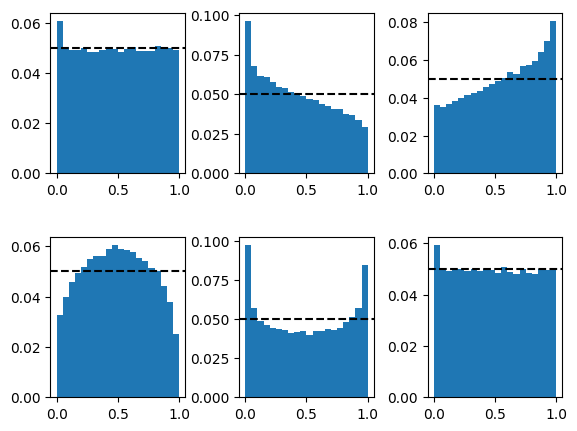

In [5]:


fig, axes = plt.subplots(2, 3)

for fcst_label, i in zip(list(hist_values.data_vars), range(6)):
    axes[int(i / 3), i % 3].bar(hist_values['bin_centre'].values, hist_values[fcst_label].values, width=1/n_bins)
    axes[int(i / 3), i % 3].axhline(y=1/n_bins, color='k', linestyle='--')

plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.4, hspace=0.4)

fig.show()

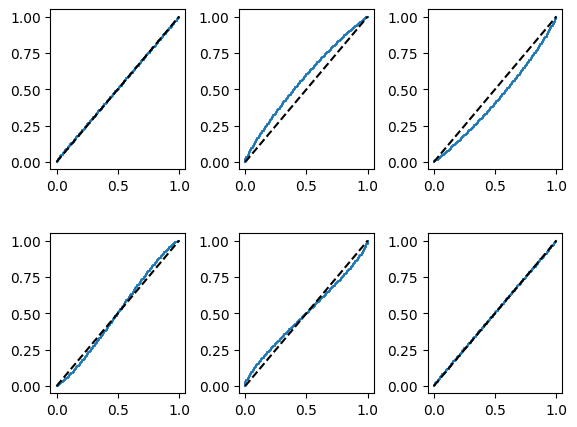

In [6]:
ppoints = pit.plotting_points()

fig, axes = plt.subplots(2, 3)

for fcst_label, i in zip(list(hist_values.data_vars), range(6)):
    axes[int(i / 3), i % 3].plot(ppoints['pit_x_value'].values, ppoints[fcst_label].values)
    axes[int(i / 3), i % 3].plot([0, 1], [0, 1], color='k', linestyle='--')

plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.4, hspace=0.4)

fig.show()

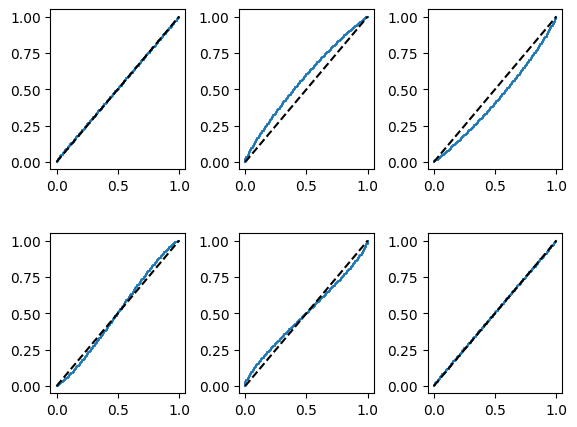

In [7]:
pppoint = pit.plotting_points_parametric()

fig, axes = plt.subplots(2, 3)

for fcst_label, i in zip(list(hist_values.data_vars), range(6)):
    axes[int(i / 3), i % 3].plot(pppoint['x_plotting_position'][fcst_label].values, pppoint['y_plotting_position'][fcst_label].values)
    axes[int(i / 3), i % 3].plot([0, 1], [0, 1], color='k', linestyle='--')

plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.4, hspace=0.4)

fig.show()

In [8]:
pit.alpha_score()

<xarray.Dataset> Size: 48B
Dimensions:  ()
Data variables:
    fcstA    float64 8B 0.005125
    fcstB    float64 8B 0.07011
    fcstC    float64 8B 0.07002
    fcstD    float64 8B 0.02542
    fcstE    float64 8B 0.03191
    fcstF    float64 8B 0.00502

In [9]:
pit_exp = pit.expected_value()
pit_var = pit.variance()
variables = list(pit_exp.data_vars)
exp_values = [float(pit_exp[variable] - 1/2) for variable in variables]
var_values = [float(pit_var[variable] - 1/12) for variable in variables]
var_values

[0.002136808047056668,
 -9.697428974335398e-05,
 5.586041990678081e-05,
 -0.013835502985583378,
 0.019184367474256683,
 0.001846371096256641]

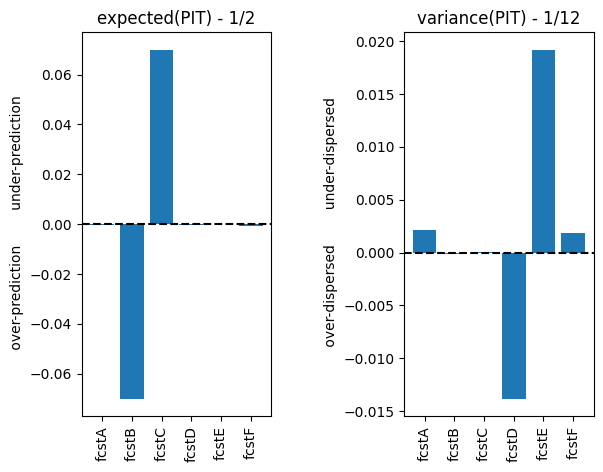

In [10]:
pit_exp = pit.expected_value()
pit_var = pit.variance()
variables = list(pit_exp.data_vars)
exp_values = [float(pit_exp[variable] - 1/2) for variable in variables]
var_values = [float(pit_var[variable] - 1/12) for variable in variables]

fig, axes = plt.subplots(1, 2)

axes[0].axhline(y=0, color='k', linestyle='--')
axes[1].axhline(y=0, color='k', linestyle='--')

axes[0].set_ylabel(' over-prediction        under-prediction')
axes[1].set_ylabel(' over-dispersed        under-dispersed')


axes[0].bar(variables, exp_values)
axes[1].bar(variables, var_values)

axes[0].tick_params(axis='x', labelrotation=90)
axes[1].tick_params(axis='x', labelrotation=90)

axes[0].set_title('expected(PIT) - 1/2')
axes[1].set_title('variance(PIT) - 1/12')

plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=.7, hspace=0.4)

fig.show()

In [15]:
fcst_clipped = fcst.clip(min=0, max=2)
obs_clipped = obs.clip(min=0, max=2)
pit_clipped = Pit(fcst_clipped, obs_clipped, 'ens_member', fcst_type='ensemble', reduce_dims='all')

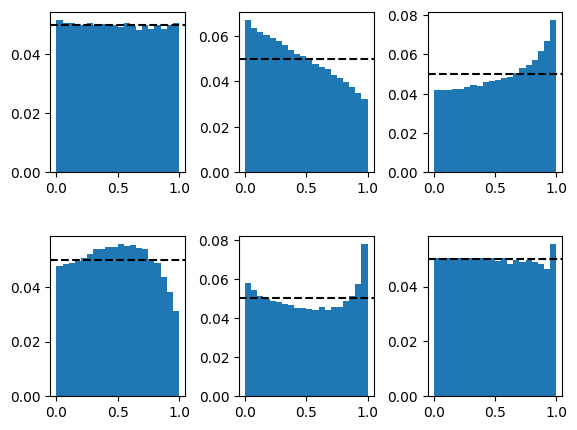

In [ ]:
n_bins = 20
hist_values_clipped = pit_clipped.hist_values(n_bins, right = True)

fig, axes = plt.subplots(2, 3)

for fcst_label, i in zip(list(hist_values_clipped.data_vars), range(6)):
    axes[int(i / 3), i % 3].bar(hist_values_clipped['bin_centre'].values, hist_values_clipped[fcst_label].values, width=1/n_bins)
    axes[int(i / 3), i % 3].axhline(y=1/n_bins, color='k', linestyle='--')

plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.4, hspace=0.4)

fig.show()

## PIT for CDFs

In [26]:
n_cases = 1000
n_x = 500
x_values = np.linspace(-10, 10, n_x)

mu = norm.rvs(loc = 0, scale = 1, size=n_cases)

obs = xr.DataArray(
    data=norm.rvs(loc = mu, scale = 1, size=n_cases),
    dims=['case'],
    coords={'case': range(n_cases)},
    name='obs',
)



da_mu = xr.DataArray(data=mu, dims=['case'], coords={'case': range(n_cases)})
da_x = xr.DataArray(data=x_values, dims=['x'], coords={'x': x_values})
da_mu, da_x = xr.broadcast(da_mu, da_x)

cdfA = xr.DataArray(
    data=norm.cdf(da_x, loc = da_mu, scale = 1),
    dims=['case', 'x'],
    coords={'x': x_values, 'case': range(n_cases)},
    name='cdfA',
)
cdfB = xr.DataArray(
    data=norm.cdf(da_x, loc = da_mu + 0.25, scale = 1),
    dims=['case', 'x'],
    coords={'x': x_values, 'case': range(n_cases)},
    name='cdfB',
)
cdfC = xr.DataArray(
    data=norm.cdf(da_x, loc = da_mu - 0.25, scale = 1),
    dims=['case', 'x'],
    coords={'x': x_values, 'case': range(n_cases)},
    name='cdfC',
)
cdfD = xr.DataArray(
    data=norm.cdf(da_x, loc = da_mu, scale = 1.2),
    dims=['case', 'x'],
    coords={'x': x_values, 'case': range(n_cases)},
    name='cdfD',
)
cdfE = xr.DataArray(
    data=norm.cdf(da_x, loc = da_mu, scale = 1 / 1.2),
    dims=['case', 'x'],
    coords={'x': x_values, 'case': range(n_cases)},
    name='cdfE',
)
cdfF = xr.DataArray(
    data=norm.cdf(da_x, loc = 0, scale = np.sqrt(2)),
    dims=['case', 'x'],
    coords={'x': x_values, 'case': range(n_cases)},
    name='cdfF',
)
cdf = xr.merge([cdfA, cdfB, cdfC, cdfD, cdfE, cdfF])
cdf


<xarray.Dataset> Size: 24MB
Dimensions:  (x: 500, case: 1000)
Coordinates:
  * x        (x) float64 4kB -10.0 -9.96 -9.92 -9.88 ... 9.88 9.92 9.96 10.0
  * case     (case) int64 8kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
Data variables:
    cdfA     (case, x) float64 4MB 4.094e-28 6.363e-28 9.873e-28 ... 1.0 1.0 1.0
    cdfB     (case, x) float64 4MB 2.524e-29 3.962e-29 6.209e-29 ... 1.0 1.0 1.0
    cdfC     (case, x) float64 4MB 6.242e-27 9.604e-27 1.476e-26 ... 1.0 1.0 1.0
    cdfD     (case, x) float64 4MB 4.149e-20 5.641e-20 7.662e-20 ... 1.0 1.0 1.0
    cdfE     (case, x) float64 4MB 1.311e-39 2.47e-39 4.642e-39 ... 1.0 1.0 1.0
    cdfF     (case, x) float64 4MB 7.687e-13 9.426e-13 1.155e-12 ... 1.0 1.0 1.0

In [27]:
pit_cdf = Pit(cdf, obs, 'x', fcst_type='cdf', reduce_dims='all')


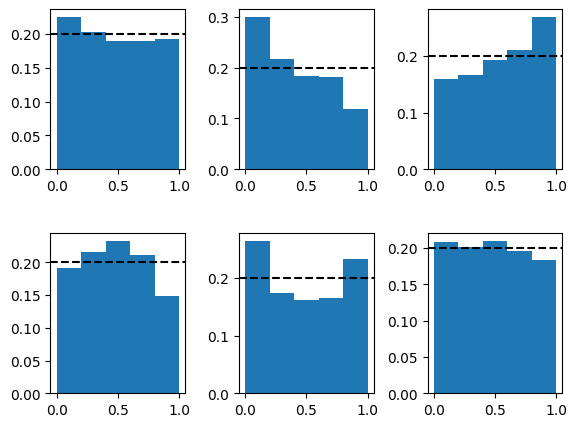

In [30]:
n_bins = 5
hist_values_cdf = pit_cdf.hist_values(n_bins, right = True)

fig, axes = plt.subplots(2, 3)

for fcst_label, i in zip(list(hist_values_cdf.data_vars), range(6)):
    axes[int(i / 3), i % 3].bar(hist_values_cdf['bin_centre'].values, hist_values_cdf[fcst_label].values, width=1/n_bins)
    axes[int(i / 3), i % 3].axhline(y=1/n_bins, color='k', linestyle='--')

plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.4, hspace=0.4)

fig.show()

## References

Renard, B., Kavetski, D., Kuczera, G., Thyer, M., & Franks, S. W. (2010). Understanding predictive uncertainty in hydrologic modeling: The challenge of identifying input and structural errors. Water Resources Research, 46(5). https://doi.org/10.1029/2009WR008328